# Dependencies

In [1]:
import numpy as np
import pandas as pd
import json
from eventgraphs import EventGraph
import matplotlib.pyplot as plt

from glob import glob
from collections import defaultdict
import pickle
import networkx as nx

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Functions For Plotting  

In [2]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(16, 8), dpi=100)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)
    labels = nx.get_edge_attributes(graph,'delta')
    nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values()) 
    ymax = cut * max(yy for xx, yy in pos.values()) 
    xmin = cut * min(xx for xx, yy in pos.values()) 
    ymin = cut * min(yy for xx, yy in pos.values()) 
    plt.xlim(1.5*xmin, 1.5*xmax)
    plt.ylim(1.5*ymin, 1.5*ymax)

    plt.savefig(file_name) #bbox_inches="tight"
    pylab.close()
    del fig

## Contact Dataset - Interactions

In [3]:
home_dir = "C:\\Users\\matth\\Documents\\IMPERIAL\\PROJECT\\covid_dataset_raw.tsv"

covid_raw = pd.read_csv(home_dir, sep='\t')

In [4]:
covid_raw.shape

(11146, 4)

In [5]:
covid_raw.head()

,source,target,t,anon_name
0,Patient_139,Patient_20,2020-11-17,renal_3
1,Patient_139,Patient_20,2020-11-18,renal_3
2,Patient_139,Patient_20,2020-11-19,renal_3
3,Patient_139,Patient_20,2020-11-20,renal_3
4,Patient_139,Patient_20,2020-11-21,renal_3


In [6]:
#rename columns

covid = covid_raw.rename(columns={"t": "time", "anon_name": "type"})

In [7]:
covid.head()

,source,target,time,type
0,Patient_139,Patient_20,2020-11-17,renal_3
1,Patient_139,Patient_20,2020-11-18,renal_3
2,Patient_139,Patient_20,2020-11-19,renal_3
3,Patient_139,Patient_20,2020-11-20,renal_3
4,Patient_139,Patient_20,2020-11-21,renal_3


In [8]:
covid['time'].value_counts()

2021-01-19    339
2021-01-14    337
2021-01-16    331
2021-01-15    320
2021-01-13    316
             ... 
2020-11-28     14
2020-11-04     13
2020-11-03     11
2020-11-02      9
2020-11-01      8
Name: time, Length: 99, dtype: int64

In [9]:
covid['type'].value_counts().head()

elderly_1        731
medicine_9       699
surgery_5        670
medicine_3       625
respiratory_2    606
Name: type, dtype: int64

In [10]:
min_dater = covid.time.min()
print(min_dater)

2020-11-01


In [11]:
max_dater = covid.time.max()
print(max_dater)

2021-02-09


In [12]:
#function to convert to date time
from datetime import date

def convert_to_datetime_obj(str_dt):
    yy, mm , dd = map(int, str_dt.split('-'))
    date_time_obj = date(yy, mm, dd)
    return date_time_obj

In [13]:
min_date = convert_to_datetime_obj(covid.time.min())

def numOfDays(datetime):
    return (datetime-min_date).days

In [14]:
covid.time = covid.time.apply(convert_to_datetime_obj)

In [15]:
covid.time = covid.time.apply(numOfDays)

In [16]:
covid.head()

,source,target,time,type
0,Patient_139,Patient_20,16,renal_3
1,Patient_139,Patient_20,17,renal_3
2,Patient_139,Patient_20,18,renal_3
3,Patient_139,Patient_20,19,renal_3
4,Patient_139,Patient_20,20,renal_3


In [17]:
#save dataset
covid.to_csv('./covid_timestamped_data.csv', index=False)

In [18]:
covid = pd.read_csv('./covid_timestamped_data.csv')

In [19]:
covid

,source,target,time,type
0,Patient_139,Patient_20,16,renal_3
1,Patient_139,Patient_20,17,renal_3
2,Patient_139,Patient_20,18,renal_3
3,Patient_139,Patient_20,19,renal_3
4,Patient_139,Patient_20,20,renal_3
...,...,...,...,...
11141,Patient_2208,Patient_2176,95,medicine_10
11142,Patient_2208,Patient_2176,96,medicine_10
11143,Patient_2262,Patient_2176,93,medicine_9
11144,Patient_2268,Patient_2198,92,medicine_9


## Covid Patient Labels

In [20]:
home_dir_covid_lab = "C:\\Users\\matth\\Documents\\IMPERIAL\\PROJECT\\covid_patient_labels.csv"

covid_raw_lab = pd.read_csv(home_dir_covid_lab)

In [21]:
covid_raw_lab.shape

(2159, 3)

In [23]:
covid_raw_lab.head()

,PtNumber,CollectDT,LoSConsec
0,Patient_2,2020-12-12,0
1,Patient_3,2021-02-01,0
2,Patient_4,2021-02-04,2
3,Patient_5,2021-01-28,0
4,Patient_7,2020-12-10,0


In [26]:
covid_raw_lab['PtNumber'].value_counts()

Patient_320     1
Patient_773     1
Patient_1762    1
Patient_1866    1
Patient_2069    1
               ..
Patient_1389    1
Patient_1615    1
Patient_1006    1
Patient_531     1
Patient_1398    1
Name: PtNumber, Length: 2159, dtype: int64

##  Event graph Creation

we are setting delta-t to be 24 -- from literature (-14 t +10)

In [24]:
EG_24 = EventGraph.from_pandas_eventlist(covid, graph_rules='teg')
EG_24.event_graph_rules['delta_cutoff'] = 24 #days
EG_24.build(verbose=False)
EG_24.calculate_edge_motifs()
nx_eg_24 = EG_24.create_networkx_event_graph(include_graph_data=True)

In [25]:
z = pd.Series(EG_24.connected_components_indices()).value_counts()
print("Number of connected components: {}".format(len(z)))
print("Number of connected components (with more than 4 events): {}".format(len(z[z>4])))

Number of connected components: 2496
Number of connected components (with more than 4 events): 823


In [26]:
PLOT_STYLE = {'lines.linewidth':2,
              'font.size':16,
              'xtick.labelsize':16,
              'ytick.labelsize':16,
              'axes.labelsize' : 16,
              'mathtext.fontset':'cm',
              'mathtext.rm' :'serif',
              'text.usetex':False
             }

## Feature Generation 

In [27]:
#filtering the event graph to only the connect components with greater than 4 events

filtered = EG_24.filter_edges(delta_ub=24)

In [28]:
# basis composition
print(f'Nodes:',filtered.N)
print(f'Events:',filtered.M)
print(f'Duration:',filtered.D)

Nodes: 1672
Events: 11146
Duration: 77


In [29]:
from eventgraphs.clustering import generate_features, FEATURE_SPEC

components = filtered.connected_components(min_size=5)
print(f'The Number of components with greater than four events', len(components))
# there are 823 components (greater than 4) - which will be the rows of the features object we create next 

The Number of components with greater than four events 823


In [31]:
#set the kwargs to be passed to the function


FEATURE_SPEC['event_graph_features'][1]['kwargs'] = {'miller_correct':False, 'k':24}
FEATURE_SPEC['event_graph_features'][2]['kwargs'] = {'miller_correct':False, 'divisions':10}
FEATURE_SPEC['event_graph_features']

[{'name': 'motifs',
  'function': <function eventgraphs.analysis.calculate_motif_distribution(eventgraph, normalize=True)>,
  'kwargs': {},
  'scale': False},
 {'name': 'motif_entropy',
  'function': <function eventgraphs.analysis.calculate_motif_entropy(eventgraph, miller_correct=False, k=None, normalize=False)>,
  'kwargs': {'miller_correct': False, 'k': 24},
  'scale': False},
 {'name': 'iet_entropy',
  'function': <function eventgraphs.analysis.calculate_iet_entropy(eventgraph, normalize=True, miller_correct=False, divisions=10)>,
  'kwargs': {'miller_correct': False, 'divisions': 10},
  'scale': False},
 {'name': 'activity',
  'function': <function eventgraphs.analysis.calculate_activity(eventgraph, unit=1, rescale=True)>,
  'kwargs': {},
  'scale': False},
 {'name': 'duration',
  'function': <function eventgraphs.clustering.<lambda>(eventgraph)>,
  'kwargs': {},
  'scale': True},
 {'name': 'num_events',
  'function': <function eventgraphs.clustering.<lambda>(eventgraph)>,
  'kwar

## Motif Distribution

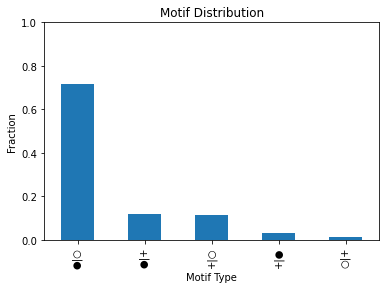

In [32]:
from eventgraphs.analysis import calculate_motif_distribution

motif_distribution = calculate_motif_distribution(filtered)

motif_distribution.nlargest().plot(kind='bar', ylim=(0,1), title='Motif Distribution', xlabel='Motif Type', 
                                   ylabel='Fraction');

In [33]:
motif_distribution_df = pd.DataFrame(motif_distribution)

In [34]:
motif_distribution_df =motif_distribution_df.rename(index={'●|○': 'ABAB', '+|○': 'ABCB', '●|+':'ABAC','○|+':' ABBC', '+|●':'ABCA'})

<AxesSubplot:title={'center':'COVID-19: Motif Distribution'}, xlabel='Motif Type', ylabel='Fraction'>

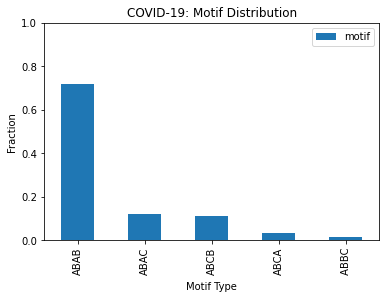

In [35]:
motif_distribution_df.plot.bar(ylim=(0,1), title='COVID-19: Motif Distribution', xlabel='Motif Type', 
                                   ylabel='Fraction')

## Creating Features

In [36]:
features, scale_features = generate_features(components, feature_spec=FEATURE_SPEC)

In [37]:
features.keys()

Index(['●|○', '+|○', '●|+', '○|+', '+|●', 'motif_entropy', 'iet_entropy',
       'activity', 'clustering_coefficient', 'reciprocity_ratio',
       'imbalance_oo', 'imbalance_oi', 'imbalance_ii'],
      dtype='object')

In [38]:
features

,●|○,+|○,●|+,○|+,+|●,motif_entropy,iet_entropy,activity,clustering_coefficient,reciprocity_ratio,imbalance_oo,imbalance_oi,imbalance_ii
256,0.626506,0.132530,0.132530,0.060241,0.048193,1.650461,0.376953,0.994752,0.137868,0.0,0.659375,0.382812,0.246875
386,0.806452,0.080645,0.048387,0.016129,0.048387,1.062064,0.168409,0.868961,0.000000,0.0,0.730769,0.346154,0.243590
821,0.568627,0.176471,0.137255,0.019608,0.098039,1.737682,0.335732,0.968779,0.000000,0.0,0.684783,0.500000,0.253623
891,0.510204,0.244898,0.204082,0.000000,0.040816,1.648685,0.308670,0.811124,0.000000,0.0,0.813333,0.460000,0.160000
273,0.541667,0.145833,0.229167,0.041667,0.041667,1.753365,0.359533,0.953229,0.103333,0.0,0.715909,0.600000,0.234848
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374,0.750000,0.000000,0.250000,0.000000,0.000000,0.811278,-0.000000,0.713495,0.000000,0.0,1.000000,1.000000,0.000000
1482,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.713495,0.000000,0.0,1.000000,0.500000,0.000000
1403,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.713495,0.000000,0.0,1.000000,0.500000,0.000000
1650,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.713495,0.000000,0.0,1.000000,0.500000,0.000000


In [39]:
features.shape

(823, 13)

In [40]:
# same as with CPE the reciprocity_ratio is all zero because we cannot revist an event that has already happend

features['reciprocity_ratio'].value_counts().head()

0.0    823
Name: reciprocity_ratio, dtype: int64

In [41]:
#we have no edge reciprocity ie no ABBA due to the nature of the event graph so remove column
features = features.drop('reciprocity_ratio', axis=1)

In [42]:
from sklearn.preprocessing import Normalizer

In [43]:
# Rescale
rs_features = Normalizer().fit_transform(features)
rs_features = pd.DataFrame(rs_features, index=features.index, columns=features.columns)

# Clustering

In [44]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from eventgraphs.clustering import find_clusters

In [45]:
silh_scores = {}
Dunn_scores = {}
cali_hara_scores = {}
#we iterate through different cluster sizes then will work out the best one
for cluster_size in range(2,12):
    clusters, cluster_centers = find_clusters(rs_features, max_clusters=cluster_size, metric='euclidean') #using defult WARD
    #compute metrics
    silh_scores[cluster_size] = silhouette_score(rs_features, clusters)
    Dunn_scores[cluster_size] = davies_bouldin_score(rs_features, clusters)
    cali_hara_scores[cluster_size] = calinski_harabasz_score(rs_features, clusters)
#save to a series
silh_scores = pd.Series(silh_scores)
Dunn_scores = pd.Series(Dunn_scores)
cali_hara_scores = pd.Series(cali_hara_scores)

In [46]:
PLOT_STYLE = {'lines.linewidth':2,
              'font.size':16,
              'xtick.labelsize':16,
              'ytick.labelsize':16,
              'axes.labelsize' : 16,
              'mathtext.fontset':'cm',
              'mathtext.rm' :'serif',
              'text.usetex':False
             }

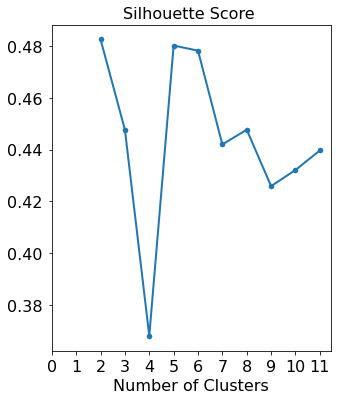

In [47]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    silh_scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    #ax.set_ylabel("Silhouette Coefficient")

    #ax.set_xlim(0,12)
    #ax.set_ylim(0.15,0.33)

    ax.set_xticks(np.arange(0,12,1));
    ax.set_title('Silhouette Score ', fontsize=16)
    fig.savefig('./figures/figure_a2a_clusters.eps', bbox_inches='tight')

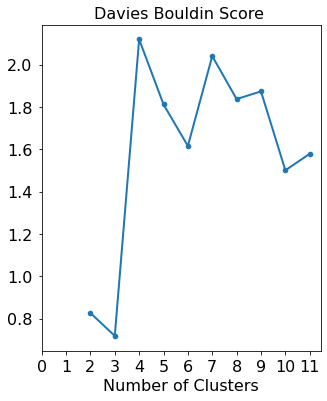

In [48]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    Dunn_scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    #ax.set_ylabel("Dunn Index (lower the better)")

    #ax.set_xlim(0,12)
    #ax.set_ylim(0.15,0.33)

    ax.set_xticks(np.arange(0,12,1));
    ax.set_title('Davies Bouldin Score ', fontsize=16)
    fig.savefig('./figures/figure_a2a_clusters.eps', bbox_inches='tight')

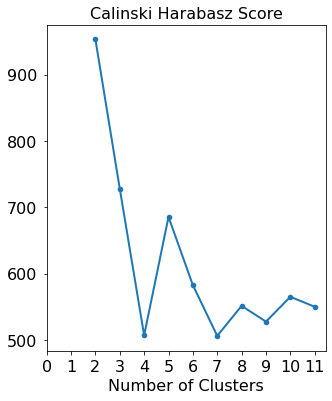

In [49]:
with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(5,6))
    ax = fig.add_subplot(111)

    cali_hara_scores.plot(marker='o', ax=ax)

    ax.set_xlabel("Number of Clusters")
    #ax.set_ylabel("calinski_harabasz_score (higher the better)")

    #ax.set_xlim(0,12)
    #ax.set_ylim(0.15,0.33)

    ax.set_xticks(np.arange(0,12,1));
    ax.set_title('Calinski Harabasz Score', fontsize=16)
    fig.savefig('./figures/figure_a2a_clusters.eps', bbox_inches='tight')

##  Set number of clusters to be FIVE

In [50]:
max_clusters = 5 # set for both analysis with and without outlier

#attain clustering for max_clusters
clusters, cluster_centers = find_clusters(rs_features, max_clusters=max_clusters, metric='euclidean')
filtered.add_cluster_assignments(clusters)

In [51]:
#create a summary table of each cluster by mean

summary = pd.concat([features.groupby(by=clusters).mean(),
                     scale_features.groupby(by=clusters).mean()],
                     axis=1)

variances = pd.concat([features.groupby(by=clusters).std(),
                     scale_features.groupby(by=clusters).std()],
                     axis=1)

def reduce_motif(motif):
    if motif.startswith('○|●'):
        return 'ABBA'
    elif motif.startswith('●|+'):
        return 'ABAC'
    elif motif.startswith('○|+'):
        return 'ABBC'
    elif motif.startswith('+|●'):
        return 'ABCA'
    elif motif.startswith('+|○'):
        return 'ABCB'
    elif motif.startswith('●|○'):
        return 'ABAB'
    else:
        return motif 
    
summary = summary.T.reset_index()
summary = summary.groupby(by=summary['index'].apply(reduce_motif)).sum()

# Transform back to original features (rather than normalised) for easier comparison
summary.loc['activity'] = -np.log(1-summary.loc['activity'])
for f in ('ii','oi','oo'):
    summary.loc['imbalance_{}'.format(f)] = 2*summary.loc['imbalance_{}'.format(f)] - 1
summary.loc['iet_entropy'] = summary.loc['iet_entropy']*np.log2(10)
summary.loc['motif_entropy'] = summary.loc['motif_entropy']*np.log2(5) # five because we have six motifs
    
summary = pd.DataFrame(summary)
summary

,1,2,3,4,5
index,,,,,
ABAB,0.564797,0.609929,0.784638,0.799478,1.000000
ABAC,0.185843,0.125885,0.215362,0.000000,0.000000
ABBC,0.005327,0.138634,0.000000,0.000000,0.000000
ABCA,0.058671,0.028720,0.000000,0.000000,0.000000
ABCB,0.185361,0.096832,0.000000,0.200522,0.000000
activity,1.225282,-22.723334,0.913387,0.921966,1.150805
clustering_coefficient,0.006357,0.135571,0.000000,0.000000,0.000000
duration,9.355491,10.291667,7.517647,7.753425,5.890688
edge_density,0.188908,0.240686,0.322549,0.328767,0.500000


In [52]:
summary_new = summary.rename(index={'activity': 'Activity', 'clustering_coefficient':'Clustering Coefficient', 
                                    'duration': 'Duration', 'edge_density': 'Edge Density', 'iet_entropy': 'IET Entropy',
                                    'imbalance_ii': 'In-In (Imbalance)', 'imbalance_oi': 'Out-In (Imbalance)',
                                    'imbalance_oo': 'Out-Out (Imbalance)', 'motif_entropy': 'Motif Entropy', 
                                    'num_events': 'Average Number of Events', 'num_nodes':'Average Number of Nodes'})

In [53]:
summary_new

,1,2,3,4,5
index,,,,,
ABAB,0.564797,0.609929,0.784638,0.799478,1.000000
ABAC,0.185843,0.125885,0.215362,0.000000,0.000000
ABBC,0.005327,0.138634,0.000000,0.000000,0.000000
ABCA,0.058671,0.028720,0.000000,0.000000,0.000000
ABCB,0.185361,0.096832,0.000000,0.200522,0.000000
Activity,1.225282,-22.723334,0.913387,0.921966,1.150805
Clustering Coefficient,0.006357,0.135571,0.000000,0.000000,0.000000
Duration,9.355491,10.291667,7.517647,7.753425,5.890688
Edge Density,0.188908,0.240686,0.322549,0.328767,0.500000


In [54]:
print(summary_new.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &          1 &          2 &         3 &         4 &         5 \\
index                    &            &            &           &           &           \\
\midrule
ABAB                     &   0.564797 &   0.609929 &  0.784638 &  0.799478 &  1.000000 \\
ABAC                     &   0.185843 &   0.125885 &  0.215362 &  0.000000 &  0.000000 \\
ABBC                     &   0.005327 &   0.138634 &  0.000000 &  0.000000 &  0.000000 \\
ABCA                     &   0.058671 &   0.028720 &  0.000000 &  0.000000 &  0.000000 \\
ABCB                     &   0.185361 &   0.096832 &  0.000000 &  0.200522 &  0.000000 \\
Activity                 &   1.225282 & -22.723334 &  0.913387 &  0.921966 &  1.150805 \\
Clustering Coefficient   &   0.006357 &   0.135571 &  0.000000 &  0.000000 &  0.000000 \\
Duration                 &   9.355491 &  10.291667 &  7.517647 &  7.753425 &  5.890688 \\
Edge Density             &   0.188908 &   0.240686 &  0.322549 &  0.328767 &  0.

In [55]:
def highlight_max(s):
    is_large = s.nlargest(3).values
    return ['background-color: yellow' if v in is_large else '' for v in s]

In [56]:

#summary.style.apply(highlight_max)
summary.style.highlight_max(color = 'lightgreen', axis = 1)
#summary.style.highlight_min(color = 'red', axis = 1)


,1,2,3,4,5
index,,,,,
ABAB,0.564797,0.609929,0.784638,0.799478,1.000000
ABAC,0.185843,0.125885,0.215362,0.000000,0.000000
ABBC,0.005327,0.138634,0.000000,0.000000,0.000000
ABCA,0.058671,0.028720,0.000000,0.000000,0.000000
ABCB,0.185361,0.096832,0.000000,0.200522,0.000000
activity,1.225282,-22.723334,0.913387,0.921966,1.150805
clustering_coefficient,0.006357,0.135571,0.000000,0.000000,0.000000
duration,9.355491,10.291667,7.517647,7.753425,5.890688
edge_density,0.188908,0.240686,0.322549,0.328767,0.500000


# PCA

In [57]:
#Feature Space plot
from eventgraphs.clustering import reduce_feature_dimensionality
from eventgraphs.plotting import plot_component_embedding

#t-SNE in 2-D - (function uses sklearn)
X, (tsne, _) = reduce_feature_dimensionality(rs_features, 
                                             ndim=2, 
                                             method='tsne',
                                             return_scalers=True, 
                                             **dict(random_state=0, 
                                                  verbose=True, 
                                                  learning_rate=500),)

#PCA in 3-D
Y, PCA = reduce_feature_dimensionality(rs_features, 
                                       ndim=10,
                                       method='pca', 
                                       return_scalers=True,)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 823 samples in 0.001s...
[t-SNE] Computed neighbors for 823 samples in 0.016s...
[t-SNE] Computed conditional probabilities for sample 823 / 823
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.641647
[t-SNE] KL divergence after 1000 iterations: 0.495095


In [58]:
print("Explained Ratio: {}".format(PCA.explained_variance_ratio_))
print("Total Explained: {}".format(sum(PCA.explained_variance_ratio_)))

Explained Ratio: [0.7431867  0.112507   0.05636091 0.0243846  0.02314638 0.01692157
 0.01227798 0.00439329 0.0029375  0.00204579]
Total Explained: 0.9981617177761538


In [59]:
s = [0.7431867,  0.112507,   0.05636091]
print(sum(s))

0.91205461


In [60]:
explained_variances = PCA.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(explained_variances)

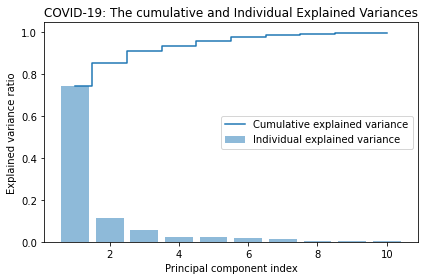

In [61]:
plt.bar(range(1,len(explained_variances) +1), explained_variances, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues) +1), cum_sum_eigenvalues, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('COVID-19: The cumulative and Individual Explained Variances')
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

In [62]:
#Feature Space plot
from eventgraphs.clustering import reduce_feature_dimensionality
from eventgraphs.plotting import plot_component_embedding

#t-SNE in 2-D - (function uses sklearn)
X, (tsne, _) = reduce_feature_dimensionality(rs_features, 
                                             ndim=2, 
                                             method='tsne',
                                             return_scalers=True, 
                                             **dict(random_state=0, 
                                                  verbose=True, 
                                                  learning_rate=500),)

#PCA in 3-D
Y, PCA = reduce_feature_dimensionality(rs_features, 
                                       ndim=3,
                                       method='pca', 
                                       return_scalers=True,)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 823 samples in 0.002s...
[t-SNE] Computed neighbors for 823 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 823 / 823
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.641647
[t-SNE] KL divergence after 1000 iterations: 0.495095


In [63]:
print("Explained Ratio: {}".format(PCA.explained_variance_ratio_))
print("Total Explained: {}".format(sum(PCA.explained_variance_ratio_)))

Explained Ratio: [0.7431867  0.112507   0.05636091]
Total Explained: 0.9120546131642446


## PCA - First three Principle Components 

In [65]:
pca_0 = Y[:,0]
pca_1 = Y[:,1]
pca_2 = Y[:,2]

## 1st and 2nd dims

In [66]:
pca_12 = []
for one, two in zip(pca_0,pca_1):
    zipped = [one,two]
    pca_12.append(zipped)

In [67]:
pca_12 = np.array(pca_12)

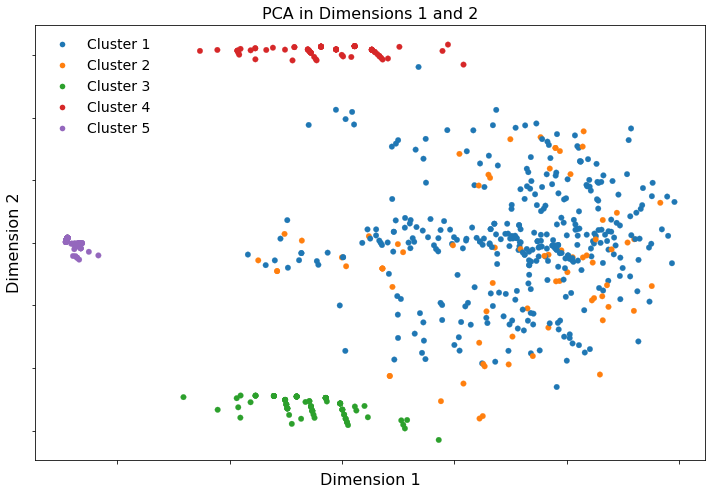

In [68]:
with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    ax = plot_component_embedding(pca_12, clusters=clusters, ax=ax);
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    plt.title('PCA in Dimensions 1 and 2', fontsize=16)
    
    #fig.savefig('./figures/figure_3_clustering.eps', bbox_inches='tight')

## 1st and 3rd dims

In [69]:
pca_13 = []
for one, two in zip(pca_0,pca_2):
    zipped = [one,two]
    pca_13.append(zipped)

In [70]:
pca_13 = np.array(pca_13)

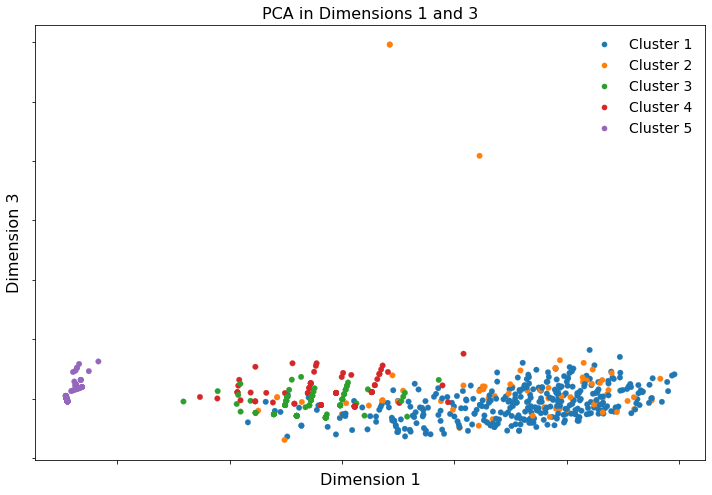

In [71]:
with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    ax = plot_component_embedding(pca_13, clusters=clusters, ax=ax);
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 3')
    plt.title('PCA in Dimensions 1 and 3', fontsize=16)
    #fig.savefig('./figures/figure_3_clustering.eps', bbox_inches='tight')

## 2nd and 3rd dims

In [72]:
pca_23 = []
for one, two in zip(pca_1,pca_2):
    zipped = [one,two]
    pca_23.append(zipped)

In [73]:
pca_23 = np.array(pca_23)

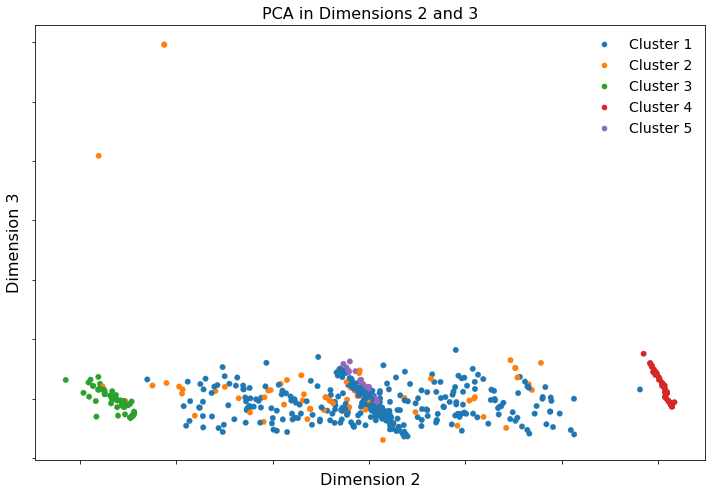

In [74]:
with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    
    ax = plot_component_embedding(pca_23, clusters=clusters, ax=ax);
    ax.set_xlabel('Dimension 2')
    ax.set_ylabel('Dimension 3')
    plt.title('PCA in Dimensions 2 and 3', fontsize=16)
    #fig.savefig('./figures/figure_3_clustering.eps', bbox_inches='tight')

In [75]:
pca_components = pd.DataFrame([features.columns[pd.Series(PCA.components_[0]).abs().nlargest(3).index],
                               features.columns[pd.Series(PCA.components_[1]).abs().nlargest(3).index],
                               features.columns[pd.Series(PCA.components_[2]).abs().nlargest(3).index],
                              ]).T
pca_components.columns = ['Component 1 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[0]), 
                          'Component 2 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[1]),
                          'Component 3 ({:.0f}%)'.format(100*PCA.explained_variance_ratio_[2]),
                          ]

pca_components = pca_components.rename(index={0: '1', 1:'2', 2:'3'})

pca_components

,Component 1 (74%),Component 2 (11%),Component 3 (6%)
1,motif_entropy,imbalance_oi,activity
2,●|○,+|○,motif_entropy
3,imbalance_oo,●|+,imbalance_oi


In [76]:
print(pca_components.to_latex())

\begin{tabular}{llll}
\toprule
{} & Component 1 (74\%) & Component 2 (11\%) & Component 3 (6\%) \\
\midrule
1 &     motif\_entropy &      imbalance\_oi &         activity \\
2 &               ●|○ &               +|○ &    motif\_entropy \\
3 &      imbalance\_oo &               ●|+ &     imbalance\_oi \\
\bottomrule
\end{tabular}



# CLUSTER ANALYSIS

In [79]:
#function to plot colour

from matplotlib import pylab
import networkx as nx
import matplotlib.patches as mpatches

def save_graph_with_colour(graph,file_name):
    
    color_map = []
    
    handles_lst = []
    
    for i in graph.nodes(data=True):
        if i[1]['type'] in ('renal_1', 'renal_2', 'renal_3', 'renal_4', 'renal_5'):
            i[1]['type'] = 'renal'
            color_map.append('blue')

        elif i[1]['type'] in ('medicine_1', 'medicine_2', 'medicine_3', 'medicine_4', 'medicine_5',' medicine_6',' medicine_7'
                              , 'medicine_8','medicine_9', 'medicine_10', ' medicine_11', 'medicine_12', 'medicine_13', 
                              'medicine_14','medicine_15', 'medicine_16', 'medicine_17', 'medicine_18', 'medicine_19', 
                              'medicine_20', 'medicine_21'):
            i[1]['type'] = 'medicine'
            color_map.append('green')
            
        elif i[1]['type'] in ('surgery_1', 'surgery_2', 'surgery_3', 'surgery_4', 'surgery_5',' surgery_6',' surgery_7'
                              , 'surgery_8','surgery_9', 'surgery_10','surgery_11','surgery_12','surgery_13', 'surgery_14'):

            i[1]['type'] = 'surgery'
            color_map.append('red')
            
            
        elif i[1]['type'] in ('elderly_1', 'elderly_2', 'elderly_3', 'elderly_4', 'elderly_5'):

            i[1]['type'] = 'elderly'
            color_map.append('brown')
            
            
        elif i[1]['type'] in ('haematology_1', 'haematology_2', 'haematology_3', 'haematology_4'):

            i[1]['type'] = 'haematology'
            color_map.append('orange')
            
            
        
        elif i[1]['type'] in ('oncology_1', 'oncology_2'):
            
            i[1]['type'] = 'oncology'
            color_map.append('yellow')
            
            
            
        elif i[1]['type'] in ('respiratory_1', 'respiratory_2'):
            i[1]['type'] = 'respiratory'
            color_map.append('grey')
        
            
            
        elif i[1]['type'] in ('critical care_1', 'critical care_2', 'critical care_3'):

            i[1]['type'] = 'critical care'
            color_map.append('black')
            
            
        
        elif i[1]['type'] in ('cardiology', 'ward na', 'cancer_1', 'OPD_1'):

            i[1]['type'] = 'cardiology/ward_na/cancer_1/OPD_1'
            color_map.append('white')
            
        else:
            color_map.append('purple')
            continue
            
    
    
    
    
    #initialze Figure
    plt.figure(num=None, figsize=(16, 8), dpi=100)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.circular_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)
    labels = nx.get_edge_attributes(graph,'delta')
    #nx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)
   
    nx.draw(graph,pos, edge_labels=labels, node_color=color_map)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values()) 
    ymax = cut * max(yy for xx, yy in pos.values()) 
    xmin = cut * min(xx for xx, yy in pos.values()) 
    ymin = cut * min(yy for xx, yy in pos.values()) 
    plt.xlim(1.5*xmin, 1.5*xmax)
    plt.ylim(1.5*ymin, 1.5*ymax)
    
    
    plt.legend(handles=handles_lst)
    
    print(handles_lst)
    plt.savefig(file_name) #bbox_inches="tight"
    pylab.close()
    del fig

## Cluster 1

In [80]:
cluster_1 = clusters[clusters == 1] # all components in cluster 1

In [81]:
cluster_1

256     1
386     1
821     1
891     1
273     1
       ..
2091    1
1187    1
1017    1
993     1
1461    1
Length: 346, dtype: int64

In [82]:
cluster_1.value_counts()

1    346
dtype: int64

In [83]:
comp_256 = components[256]
comp_256

<EventGraph with 21 nodes, 84 events, and 83 edges (status: built)>

In [84]:
comp_273 = components[273]
comp_273

<EventGraph with 20 nodes, 49 events, and 48 edges (status: built)>

In [85]:
comp_2091 = components[2091]
comp_2091

<EventGraph with 5 nodes, 5 events, and 4 edges (status: built)>

In [86]:
comp_1461 = components[1461]
comp_1461

<EventGraph with 5 nodes, 5 events, and 4 edges (status: built)>

In [87]:
for ix, component in enumerate(cluster_1.index):
    print('')
    print(f'component {component}')
    component = filtered.events[filtered.events_meta.component == component]
    print(component)


component 256
            source       target  time       type
1009  Patient_1782  Patient_116    58  surgery_5
1010  Patient_1782  Patient_116    59  surgery_5
1011  Patient_1782  Patient_116    60  surgery_5
1588  Patient_1294  Patient_463    52  surgery_8
1589  Patient_1294  Patient_463    55  surgery_8
...            ...          ...   ...        ...
7230   Patient_984  Patient_951    72  surgery_8
7231   Patient_984  Patient_951    73  surgery_8
7374  Patient_1007  Patient_984    74  surgery_5
7375  Patient_1007  Patient_984    75  surgery_5
7376  Patient_1010  Patient_984    74  surgery_5

[84 rows x 4 columns]

component 386
           source       target  time       type
1509  Patient_666  Patient_388    58  elderly_5
1510  Patient_666  Patient_388    59  elderly_5
1511  Patient_666  Patient_388    60  elderly_5
3911  Patient_142  Patient_140    70  elderly_5
3912  Patient_142  Patient_140    71  elderly_5
...           ...          ...   ...        ...
7036  Patient_943  Pati

            source        target  time           type
4495  Patient_2185   Patient_230    65     medicine_9
5012  Patient_2185   Patient_328    66  gynaecology_3
6487  Patient_1311   Patient_643    65     medicine_9
6488  Patient_1389   Patient_643    66  gynaecology_3
6489  Patient_1389   Patient_643    67  gynaecology_3
6490  Patient_1389   Patient_643    68  gynaecology_3
6491  Patient_1613   Patient_643    69  gynaecology_3
6492  Patient_1613   Patient_643    70  gynaecology_3
6493  Patient_1613   Patient_643    71  gynaecology_3
7929  Patient_2185  Patient_1106    67  gynaecology_3
7930  Patient_2185  Patient_1106    68  gynaecology_3
7931  Patient_2185  Patient_1106    69  gynaecology_3
7932  Patient_2185  Patient_1106    70  gynaecology_3
7933  Patient_2185  Patient_1106    71  gynaecology_3
8369  Patient_1613  Patient_1160    73  gynaecology_3
8370  Patient_2185  Patient_1160    74  gynaecology_3

component 73
           source        target  time             type
249  Patient_

5946  Patient_1612  Patient_501    86  elderly_3

component 2113
             source        target  time        type
9385   Patient_1872  Patient_1475    62  medicine_3
10119  Patient_1844  Patient_1821    64  medicine_3
10120  Patient_1872  Patient_1821    65  surgery_13
10121  Patient_1946  Patient_1821    62  medicine_3
10122  Patient_1946  Patient_1821    63  medicine_3
10123  Patient_2141  Patient_1821    67  surgery_13
10124  Patient_2141  Patient_1821    68  surgery_13
10125  Patient_2141  Patient_1821    69  surgery_13
10126  Patient_2141  Patient_1821    70  surgery_13
10163  Patient_1946  Patient_1844    69   elderly_1
10164  Patient_1946  Patient_1844    70   elderly_1

component 72
           source       target  time             type
241   Patient_891  Patient_404     4  critical care_1
242   Patient_891  Patient_404     5  critical care_1
243   Patient_891  Patient_404     6  critical care_1
244  Patient_1565  Patient_404     8  critical care_1
245  Patient_1565  Patient_

9399  Patient_2133  Patient_1484    76   elderly_1

component 874
            source       target  time        type
3575   Patient_617   Patient_74    83  medicine_3
3760   Patient_617  Patient_110    84  medicine_3
3761   Patient_617  Patient_110    85  medicine_3
3762  Patient_1104  Patient_110    86  surgery_13
3763  Patient_1104  Patient_110    87  surgery_13
3764  Patient_1104  Patient_110    88  surgery_13
3765  Patient_1104  Patient_110    89  surgery_13
3766  Patient_1104  Patient_110    90  surgery_13

component 899
           source       target  time        type
3629  Patient_507   Patient_89    72  medicine_2
3630  Patient_860   Patient_89    77  medicine_3
3631  Patient_860   Patient_89    78  medicine_3
5259  Patient_507  Patient_378    79   elderly_1
5260  Patient_507  Patient_378    80   elderly_1
5261  Patient_507  Patient_378    81   elderly_1
5262  Patient_507  Patient_378    82   elderly_1
5263  Patient_507  Patient_378    83   elderly_1

component 1018
            

1366  Patient_1021  Patient_270    55  medicine_10

component 1542
            source       target  time        type
6526   Patient_708  Patient_648    63  medicine_3
6527   Patient_764  Patient_648    64  medicine_3
6913  Patient_1128  Patient_764    68  medicine_3
6914  Patient_1128  Patient_764    69  medicine_3
6915  Patient_1128  Patient_764    70  medicine_3
6916  Patient_1128  Patient_764    71  medicine_3

component 1335
            source       target  time        type
5536  Patient_1082  Patient_425    62   elderly_1
5537  Patient_1082  Patient_425    63   elderly_1
5538  Patient_1082  Patient_425    64   elderly_1
5539  Patient_1082  Patient_425    65   elderly_1
5540  Patient_1112  Patient_425    67  medicine_3
6765  Patient_1082  Patient_719    67   elderly_1

component 606
            source        target  time             type
2533  Patient_2221  Patient_1022    52       medicine_6
2550  Patient_1660  Patient_1025    53       medicine_6
2551  Patient_2221  Patient_1025  

In [88]:
comp_273_nx = comp_273.create_networkx_event_graph()

In [89]:
save_graph_with_colour(comp_273_nx, 'comp_273_covid.png')

[]


<img src = 'comp_273_covid.png'>

In [98]:
for i in range(1094, 1096):
    print(covid.loc[[i]])

            source       target  time        type
1094  Patient_1714  Patient_138    56  medicine_9
            source       target  time           type
1095  Patient_1718  Patient_138    60  gynaecology_3


In [99]:
for i in range(1159, 1161):
    print(covid.loc[[i]])

            source       target  time           type
1159  Patient_1714  Patient_179    59  respiratory_1
            source       target  time           type
1160  Patient_1714  Patient_179    60  respiratory_1


In [100]:
print(covid.loc[[4241]])

            source       target  time           type
4241  Patient_1388  Patient_179    61  respiratory_1


In [101]:
for i in range(2786, 2788):
    print(covid.loc[[i]])

            source        target  time        type
2786  Patient_1947  Patient_1388    55  medicine_9
            source        target  time        type
2787  Patient_2266  Patient_1388    58  medicine_7


In [102]:
for i in range(2788, 2803):
    print(covid.loc[[i]])

            source        target  time           type
2788  Patient_1403  Patient_1398    42  respiratory_1
            source        target  time           type
2789  Patient_1403  Patient_1398    43  respiratory_1
            source        target  time           type
2790  Patient_1403  Patient_1398    44  respiratory_1
            source        target  time           type
2791  Patient_1403  Patient_1398    45  respiratory_1
            source        target  time           type
2792  Patient_1403  Patient_1398    46  respiratory_1
            source        target  time           type
2793  Patient_1403  Patient_1398    47  respiratory_1
            source        target  time           type
2794  Patient_1403  Patient_1398    48  respiratory_1
            source        target  time           type
2795  Patient_1403  Patient_1398    49  respiratory_1
            source        target  time           type
2796  Patient_1403  Patient_1398    50  respiratory_1
            source        ta

In [103]:
print(covid.loc[[4243]])

            source       target  time           type
4243  Patient_1714  Patient_179    61  respiratory_1


In [104]:
print(covid.loc[[7732]])

            source        target  time           type
7732  Patient_1714  Patient_1081    62  respiratory_1


In [105]:
for i in range(8848, 8853):
    print(covid.loc[[i]])

            source        target  time           type
8848  Patient_1714  Patient_1289    64  respiratory_1
            source        target  time        type
8849  Patient_1741  Patient_1289    69  surgery_22
            source        target  time        type
8850  Patient_1741  Patient_1289    70  surgery_22
            source        target  time        type
8851  Patient_1741  Patient_1289    71  surgery_22
            source        target  time        type
8852  Patient_1741  Patient_1289    72  surgery_22


In [90]:
comp_1461_nx = comp_1461.create_networkx_event_graph()

In [91]:
save_graph_with_colour(comp_1461_nx, 'comp_1461_covid.png')

[]


<img src = 'comp_1461_covid.png'>

In [108]:
for i in range(6146, 6148):
    print(covid.loc[[i]])

            source       target  time        type
6146  Patient_1541  Patient_554    71  medicine_3
            source       target  time        type
6147  Patient_1541  Patient_554    72  medicine_3


In [109]:
for i in range(6714, 6716):
    print(covid.loc[[i]])

            source       target  time        type
6714  Patient_1541  Patient_696    73  surgery_13
            source       target  time        type
6715  Patient_1628  Patient_696    74  surgery_13


In [110]:
print(covid.loc[[6758]])

            source       target  time        type
6758  Patient_1628  Patient_715    78  medicine_2


## Cluster 2

In [92]:
cluster_2 = clusters[clusters == 2] # all components in cluster 2

In [93]:
cluster_2

139     2
1119    2
1082    2
479     2
665     2
       ..
777     2
650     2
674     2
710     2
1505    2
Length: 72, dtype: int64

In [94]:
cluster_2.value_counts()

2    72
dtype: int64

In [95]:
comp_139 = components[139]
comp_139

<EventGraph with 14 nodes, 32 events, and 31 edges (status: built)>

In [96]:
comp_479 = components[479]
comp_479

<EventGraph with 11 nodes, 23 events, and 22 edges (status: built)>

In [97]:
comp_777 = components[777]
comp_777

<EventGraph with 3 nodes, 5 events, and 5 edges (status: built)>

In [98]:
comp_1505 = components[1505]
comp_1505

<EventGraph with 3 nodes, 5 events, and 4 edges (status: built)>

In [99]:
comp_777_nx = comp_777.create_networkx_event_graph()

In [100]:
save_graph_with_colour(comp_777_nx, 'comp_777_covid.png')

[]


<img src = 'comp_777_covid.png'>

In [101]:
for i in range(3273, 3277):
    print(covid.loc[[i]])

            source        target  time           type
3273  Patient_2166  Patient_2106    40  respiratory_1
            source        target  time           type
3274  Patient_2166  Patient_2106    41  respiratory_1
            source        target  time           type
3275  Patient_2166  Patient_2106    42  respiratory_1
            source        target  time         type
3276  Patient_2210  Patient_2106    43  medicine_10


In [102]:
print(covid.loc[[3278]])

            source        target  time         type
3278  Patient_2210  Patient_2166    46  medicine_10


In [103]:
comp_139_nx = comp_139.create_networkx_event_graph()

In [104]:
save_graph_with_colour(comp_139_nx, 'comp_139_covid.png')

[]


<img src = 'comp_139_covid.png'>

In [124]:
print(covid.loc[[565]])

          source       target  time        type
565  Patient_929  Patient_925    19  medicine_7


In [125]:
print(covid.loc[[572]])

           source       target  time        type
572  Patient_2171  Patient_929    23  medicine_7


In [126]:
for i in range(586, 588):
    print(covid.loc[[i]])

           source       target  time        type
586  Patient_2171  Patient_947    27  medicine_7
           source       target  time        type
587  Patient_2171  Patient_947    28  medicine_7


In [127]:
for i in range(2193, 2199):
    print(covid.loc[[i]])

           source       target  time        type
2193  Patient_947  Patient_946    30  medicine_7
            source       target  time         type
2194  Patient_1315  Patient_946    37  medicine_10
            source       target  time         type
2195  Patient_1627  Patient_946    42  medicine_10
            source       target  time         type
2196  Patient_1627  Patient_946    43  medicine_10
            source       target  time         type
2197  Patient_1627  Patient_946    44  medicine_10
            source       target  time         type
2198  Patient_1627  Patient_946    45  medicine_10


## Cluster 3

In [105]:
cluster_3 = clusters[clusters == 3] # all components in cluster 3

In [106]:
cluster_3

2059    3
2070    3
92      3
1300    3
2215    3
       ..
690     3
1275    3
1365    3
1378    3
374     3
Length: 85, dtype: int64

In [107]:
cluster_3.value_counts()

3    85
dtype: int64

In [108]:
comp_2059 = components[2059]
comp_2059

<EventGraph with 3 nodes, 17 events, and 16 edges (status: built)>

In [109]:
comp_92 = components[92]
comp_92

<EventGraph with 4 nodes, 11 events, and 10 edges (status: built)>

In [110]:
comp_2215 = components[2215]
comp_2215

<EventGraph with 3 nodes, 10 events, and 9 edges (status: built)>

In [111]:
comp_690 = components[690]
comp_690

<EventGraph with 3 nodes, 5 events, and 4 edges (status: built)>

In [112]:
comp_374 = components[374]
comp_374

<EventGraph with 3 nodes, 5 events, and 4 edges (status: built)>

In [113]:
# ALL HAVE RELATIVELY LOW EVENT NUMBER - ALSO ONLY 3 NODES? - NO see cluster_3_node_lst

In [114]:
comp_2215_nx = comp_2215.create_networkx_event_graph()

In [115]:
save_graph_with_colour(comp_2215_nx, 'comp_2215_covid.png')

[]


<img src = 'comp_2215_covid.png'>

In [116]:
# single string!

In [117]:
for i in range(9794, 9803):
    print(covid.loc[[i]])

            source        target  time       type
9794  Patient_1856  Patient_1665    62  surgery_5
            source        target  time       type
9795  Patient_1856  Patient_1665    63  surgery_5
            source        target  time       type
9796  Patient_1856  Patient_1665    64  surgery_5
            source        target  time       type
9797  Patient_1856  Patient_1665    65  surgery_5
            source        target  time       type
9798  Patient_1856  Patient_1665    66  surgery_5
            source        target  time       type
9799  Patient_1856  Patient_1665    67  surgery_8
            source        target  time       type
9800  Patient_1856  Patient_1665    68  surgery_8
            source        target  time       type
9801  Patient_1856  Patient_1665    69  surgery_8
            source        target  time       type
9802  Patient_1856  Patient_1665    70  surgery_8


In [118]:
print(covid.loc[[10108]])

             source        target  time       type
10108  Patient_1856  Patient_1816    80  surgery_8


In [119]:
comp_92_nx = comp_92.create_networkx_event_graph()

In [120]:
save_graph_with_colour(comp_92_nx, 'comp_92_covid.png')

[]


<img src = 'comp_92_covid.png'>

In [121]:
print(cluster_3)

2059    3
2070    3
92      3
1300    3
2215    3
       ..
690     3
1275    3
1365    3
1378    3
374     3
Length: 85, dtype: int64


In [145]:
for ix, component in enumerate(cluster_3.index):
    print('')
    print(f'component {component}')
    component = filtered.events[filtered.events_meta.component == component]
    print(component)


component 2059
            source        target  time       type
9101  Patient_2222  Patient_1394    66  elderly_5
9102  Patient_2222  Patient_1394    67  elderly_5
9103  Patient_2222  Patient_1394    68  elderly_5
9104  Patient_2222  Patient_1394    69  elderly_5
9105  Patient_2222  Patient_1394    70  elderly_5
9106  Patient_2222  Patient_1394    71  elderly_5
9107  Patient_2222  Patient_1394    72  elderly_5
9108  Patient_2222  Patient_1394    73  elderly_5
9109  Patient_2222  Patient_1394    74  elderly_5
9110  Patient_2222  Patient_1394    75  elderly_5
9111  Patient_2222  Patient_1394    76  elderly_5
9112  Patient_2222  Patient_1394    77  elderly_5
9113  Patient_2222  Patient_1394    78  elderly_5
9304  Patient_2222  Patient_1444    80  elderly_5
9305  Patient_2222  Patient_1444    81  elderly_5
9306  Patient_2222  Patient_1444    82  elderly_5
9307  Patient_2222  Patient_1444    83  elderly_5

component 2070
            source        target  time       type
9191  Patient_1856

            source        target  time           type
8191  Patient_1148  Patient_1142    73  respiratory_1
8192  Patient_1148  Patient_1143    74     surgery_22
8193  Patient_1148  Patient_1143    75     surgery_22
8194  Patient_1148  Patient_1143    76     surgery_22
8195  Patient_1148  Patient_1143    77     surgery_22

component 2203
             source        target  time           type
9749   Patient_2258  Patient_1644    61     medicine_6
9919   Patient_2258  Patient_1714    62  respiratory_1
9920   Patient_2258  Patient_1714    63  respiratory_1
9921   Patient_2258  Patient_1714    64  respiratory_1
10206  Patient_2258  Patient_1869    65     medicine_7

component 114
           source       target  time     type
449  Patient_1360  Patient_753     3  renal_3
450  Patient_1360  Patient_753     4  renal_3
451  Patient_1360  Patient_753     5  renal_3
452  Patient_1360  Patient_753     6  renal_3
488  Patient_1360  Patient_877     9  Ward_na

component 1994
            source     

In [146]:
comp_1926 = components[1926]
comp_1926

<EventGraph with 4 nodes, 8 events, and 7 edges (status: built)>

In [148]:
comp_1926_nx = comp_1926.create_networkx_event_graph()

In [149]:
save_graph_with_colour(comp_1926_nx, 'comp_1926_covid.png')

[]


<img src = 'comp_1926_covid.png'>

## Cluster 4

In [122]:
cluster_4 = clusters[clusters == 4] # all components in cluster 4

In [123]:
cluster_4

1417    4
1329    4
160     4
533     4
965     4
       ..
1882    4
2178    4
2094    4
1761    4
1498    4
Length: 73, dtype: int64

In [124]:
cluster_4.value_counts()

4    73
dtype: int64

In [125]:
comp_1417 = components[1417]
comp_1417

<EventGraph with 3 nodes, 14 events, and 13 edges (status: built)>

In [126]:
comp_965 = components[965]
comp_965

<EventGraph with 3 nodes, 11 events, and 10 edges (status: built)>

In [127]:
comp_1882 = components[1882]
comp_1882

<EventGraph with 3 nodes, 5 events, and 4 edges (status: built)>

In [128]:
comp_1498 = components[1498]
comp_1498

<EventGraph with 4 nodes, 5 events, and 4 edges (status: built)>

In [130]:
comp_965_nx = comp_965.create_networkx_event_graph()

In [143]:
save_graph_with_colour(comp_965_nx, 'comp_965_covid.png')

[]


<img src = 'comp_965_covid.png'>

In [141]:
for i in range(3919, 3930):
    print(covid.loc[[i]])

           source       target  time       type
3919  Patient_500  Patient_140    68  elderly_5
           source       target  time       type
3920  Patient_500  Patient_140    69  elderly_5
           source       target  time       type
3921  Patient_500  Patient_140    70  elderly_5
           source       target  time       type
3922  Patient_500  Patient_140    71  elderly_5
           source       target  time       type
3923  Patient_500  Patient_140    72  elderly_5
           source       target  time       type
3924  Patient_500  Patient_140    73  elderly_5
           source       target  time       type
3925  Patient_500  Patient_140    74  elderly_5
           source       target  time       type
3926  Patient_500  Patient_140    75  elderly_5
           source       target  time       type
3927  Patient_803  Patient_140    79  elderly_5
           source       target  time       type
3928  Patient_803  Patient_140    80  elderly_5
           source       target  time    

## Cluster 5

In [132]:
cluster_5 = clusters[clusters == 5] # all components in cluster 5

In [133]:
cluster_5

970     5
324     5
1561    5
1685    5
1328    5
       ..
1530    5
71      5
1482    5
1403    5
1650    5
Length: 247, dtype: int64

In [134]:
cluster_5.value_counts()

5    247
dtype: int64

In [135]:
comp_970 = components[970]
comp_970

<EventGraph with 2 nodes, 18 events, and 17 edges (status: built)>

In [136]:
comp_1328 = components[1328]
comp_1328

<EventGraph with 2 nodes, 15 events, and 14 edges (status: built)>

In [137]:
comp_1530 = components[1530]
comp_1530

<EventGraph with 2 nodes, 5 events, and 4 edges (status: built)>

In [138]:
comp_1650 = components[1650]
comp_1650

<EventGraph with 2 nodes, 5 events, and 4 edges (status: built)>

In [140]:
comp_1328_nx = comp_1328.create_networkx_event_graph()

In [142]:
save_graph_with_colour(comp_1328_nx, 'comp_1328_covid.png')

[]


<img src = 'comp_1328_covid.png'>

In [153]:
# single string!

In [154]:
for i in range(5489, 5504):
    print(covid.loc[[i]])

            source       target  time       type
5489  Patient_1317  Patient_410    73  elderly_4
            source       target  time       type
5490  Patient_1317  Patient_410    74  elderly_4
            source       target  time       type
5491  Patient_1317  Patient_410    75  elderly_4
            source       target  time       type
5492  Patient_1317  Patient_410    76  elderly_4
            source       target  time       type
5493  Patient_1317  Patient_410    77  elderly_4
            source       target  time       type
5494  Patient_1317  Patient_410    78  elderly_4
            source       target  time       type
5495  Patient_1317  Patient_410    79  elderly_4
            source       target  time       type
5496  Patient_1317  Patient_410    80  elderly_4
            source       target  time       type
5497  Patient_1317  Patient_410    81  elderly_4
            source       target  time       type
5498  Patient_1317  Patient_410    82  elderly_4
            source  

In [237]:
for ix, component in enumerate(cluster_5.index):
    print('')
    print(f'component {component}')
    component = filtered.events[filtered.events_meta.component == component]
    print(component)


component 970
            source       target  time       type
3953  Patient_2222  Patient_140    63  elderly_5
3954  Patient_2222  Patient_140    64  elderly_5
3955  Patient_2222  Patient_140    65  elderly_5
3956  Patient_2222  Patient_140    66  elderly_5
3957  Patient_2222  Patient_140    67  elderly_5
3958  Patient_2222  Patient_140    68  elderly_5
3959  Patient_2222  Patient_140    69  elderly_5
3960  Patient_2222  Patient_140    70  elderly_5
3961  Patient_2222  Patient_140    71  elderly_5
3962  Patient_2222  Patient_140    72  elderly_5
3963  Patient_2222  Patient_140    73  elderly_5
3964  Patient_2222  Patient_140    74  elderly_5
3965  Patient_2222  Patient_140    75  elderly_5
3966  Patient_2222  Patient_140    76  elderly_5
3967  Patient_2222  Patient_140    77  elderly_5
3968  Patient_2222  Patient_140    78  elderly_5
3969  Patient_2222  Patient_140    80  elderly_5
3970  Patient_2222  Patient_140    81  elderly_5

component 324
           source       target  time   

          source       target  time           type
40  Patient_1507  Patient_104     6  respiratory_2
41  Patient_1507  Patient_104     7  respiratory_2
42  Patient_1507  Patient_104     8  respiratory_2
43  Patient_1507  Patient_104     9  respiratory_2
44  Patient_1507  Patient_104    10  respiratory_2
45  Patient_1507  Patient_104    11  respiratory_2
46  Patient_1507  Patient_104    12  respiratory_2

component 1131
            source       target  time         type
4555  Patient_2250  Patient_242    65  medicine_10
4556  Patient_2250  Patient_242    66  medicine_10
4557  Patient_2250  Patient_242    67  medicine_10
4558  Patient_2250  Patient_242    68  medicine_10
4559  Patient_2250  Patient_242    69  medicine_10
4560  Patient_2250  Patient_242    70  medicine_10
4561  Patient_2250  Patient_242    71  medicine_10

component 1705
            source        target  time       type
7419  Patient_1010  Patient_1007    68  surgery_5
7420  Patient_1010  Patient_1007    69  surgery_5
74

            source       target  time           type
7180  Patient_1578  Patient_941    64  respiratory_2
7181  Patient_1578  Patient_941    65  respiratory_2
7182  Patient_1578  Patient_941    66  respiratory_2
7183  Patient_1578  Patient_941    67  respiratory_2
7184  Patient_1578  Patient_941    68  respiratory_2

component 1927
            source        target  time     type
8510  Patient_2061  Patient_1178    75  Ward_na
8511  Patient_2061  Patient_1178    76  Ward_na
8512  Patient_2061  Patient_1178    77  Ward_na
8513  Patient_2061  Patient_1178    78  Ward_na
8514  Patient_2061  Patient_1178    79  Ward_na

component 2153
            source        target  time             type
9539  Patient_1994  Patient_1567    61  critical care_2
9540  Patient_1994  Patient_1567    62  critical care_2
9541  Patient_1994  Patient_1567    63  critical care_2
9542  Patient_1994  Patient_1567    64  critical care_2
9543  Patient_1994  Patient_1567    65  critical care_2

component 1619
          

In [144]:
#function which prints the number of nodes in each component in a cluster
def printer(cluster):
    
    cluster_df = pd.DataFrame(cluster)
    outbreaks = cluster_df.index.values
    node_lst = []
    
    for out in outbreaks:
        node_lst.append(components[out].N)
    
    return np.transpose(node_lst)

In [145]:
cluster_1_node_lst = printer(cluster_1)
cluster_1_node_lst

# look at the diversity in the number of nodes(unique patients)

array([21, 13, 23, 26, 20, 18, 22, 22, 14, 16, 12, 17, 15,  8, 14, 16, 13,
        8,  8, 11, 14, 12, 12, 11, 12,  7, 11, 10, 14, 12, 10,  7,  9, 11,
       12, 10,  5, 13,  8, 10, 12,  6, 16,  4,  6,  7,  7, 14,  6,  4,  8,
        5, 10,  4, 10,  5, 11,  9,  8, 11,  5, 12,  6,  9, 10,  7,  5,  6,
        5, 10,  8,  7,  8,  5, 10,  6,  4,  5,  4,  9,  8,  5,  5,  5,  6,
        9,  6,  8,  6,  4,  8,  7,  8,  4, 11,  7,  5,  6,  4,  5,  6,  7,
        8,  7,  5,  6,  5,  6,  7,  8,  6,  5,  5,  9,  4,  6,  8,  5,  8,
        5,  8,  4, 10,  6,  9,  5,  4,  5,  4,  6,  6,  7,  4,  7,  6,  6,
        4,  6,  4,  4,  6,  7,  4,  6,  5,  7,  6,  4,  6,  4,  5,  5,  5,
        5,  6,  6,  3,  4,  9,  5,  8,  5,  6,  4,  7,  3,  7,  6,  9,  7,
        4,  4,  6,  4,  6,  4,  5,  3,  5,  5,  5,  7,  6,  6,  5,  7,  3,
        6,  4,  4,  4,  4,  4,  4,  8,  7,  4,  4,  4,  8,  5,  4,  4,  5,
        8,  6,  4,  4,  5,  4,  4,  5,  4,  4,  6,  4,  4,  4,  6,  6,  6,
        8,  6,  5,  5,  6

In [146]:
cluster_2_node_lst = printer(cluster_2)
cluster_2_node_lst

array([14, 13, 16, 11,  9,  6,  3,  7,  6,  7, 12,  6,  6,  7,  7,  7,  8,
        4,  6,  3,  5,  5,  5,  5,  3,  5,  3,  5,  5,  3,  5,  3,  5,  6,
        3,  5,  3,  6,  5,  5,  6,  3,  7,  4,  5,  4,  6,  5,  4,  4,  3,
        6,  5,  4,  4,  3,  4,  4,  3,  4,  4,  5,  5,  6,  5,  3,  4,  3,
        4,  3,  3,  3])

In [147]:
cluster_3_node_lst = printer(cluster_3)
cluster_3_node_lst

array([3, 3, 4, 3, 3, 3, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [148]:
cluster_4_node_lst = printer(cluster_4)
cluster_4_node_lst

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 4])

In [149]:
cluster_5_node_lst = printer(cluster_5)
cluster_5_node_lst

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

## Covid - Interactions Dataset

In [22]:
covid

,source,target,time,type
0,Patient_139,Patient_20,16,renal_3
1,Patient_139,Patient_20,17,renal_3
2,Patient_139,Patient_20,18,renal_3
3,Patient_139,Patient_20,19,renal_3
4,Patient_139,Patient_20,20,renal_3
...,...,...,...,...
11141,Patient_2208,Patient_2176,95,medicine_10
11142,Patient_2208,Patient_2176,96,medicine_10
11143,Patient_2262,Patient_2176,93,medicine_9
11144,Patient_2268,Patient_2198,92,medicine_9


In [23]:
#lets add a column to say whether hospital or comunity aquired

covid_raw_lab['acquired'] = np.where(covid_raw_lab['LoSConsec'] < 7, 'community', 'hospital')

In [24]:
#lets add a column to say whether hospital or comunity aquired

covid_raw_lab['acquired'] = np.where(covid_raw_lab['LoSConsec'] < 7, 1, 0)

In [25]:
covid_raw_lab.head()

,PtNumber,CollectDT,LoSConsec,acquired
0,Patient_2,2020-12-12,0,1
1,Patient_3,2021-02-01,0,1
2,Patient_4,2021-02-04,2,1
3,Patient_5,2021-01-28,0,1
4,Patient_7,2020-12-10,0,1


In [26]:
#Anything above seven or more days we will define as hospital-acquired.

In [27]:
hosp_acquired = covid_raw_lab[covid_raw_lab['LoSConsec'] >= 7]
hosp_acquired
hosp_acquired

,PtNumber,CollectDT,LoSConsec,acquired
26,Patient_29,2021-01-17,8,0
63,Patient_68,2021-01-27,7,0
72,Patient_78,2021-02-03,14,0
74,Patient_80,2020-12-11,13,0
78,Patient_84,2021-01-17,14,0
...,...,...,...,...
2079,Patient_2222,2021-01-17,14,0
2083,Patient_2226,2021-01-03,14,0
2107,Patient_2250,2021-01-01,12,0
2120,Patient_2263,2020-12-16,13,0


In [28]:
com_acquired  = covid_raw_lab[covid_raw_lab['LoSConsec'] <7]

In [29]:
com_acquired

,PtNumber,CollectDT,LoSConsec,acquired
0,Patient_2,2020-12-12,0,1
1,Patient_3,2021-02-01,0,1
2,Patient_4,2021-02-04,2,1
3,Patient_5,2021-01-28,0,1
4,Patient_7,2020-12-10,0,1
...,...,...,...,...
2154,Patient_2298,2021-01-02,0,1
2155,Patient_2299,2021-01-04,0,1
2156,Patient_2300,2021-01-10,0,1
2157,Patient_2301,2021-02-05,6,1


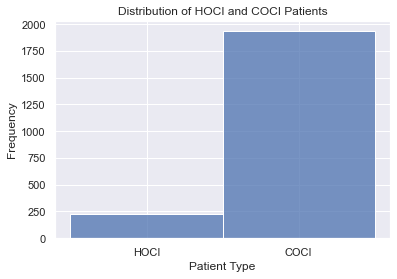

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
h = sns.histplot(covid_raw_lab['acquired'], bins=[0,1, 2])
plt.xlabel('Patient Type')
plt.ylabel('Frequency')
plt.title('Distribution of HOCI and COCI Patients')


h.set_xticks([0.5, 1.5])
h.set_xticklabels(["HOCI", "COCI"])

plt.show()

## Plot of community vs Hospital Acquired - Not Included in Thesis 

In [181]:
#get event graph

EG_24 = EventGraph.from_pandas_eventlist(covid, graph_rules='teg')
EG_24.event_graph_rules['delta_cutoff'] = 24 #days
EG_24.build(verbose=False)
EG_24.calculate_edge_motifs() # in order to include_graph_data

EG_24.filter_edges(delta_ub=24)
EG_24.connected_components(min_size=5)

nx_eg_24 = EG_24.create_networkx_event_graph(include_graph_data=True)

In [182]:
pat_edge_dict = {}
for inn, out in nx_eg_24.edges:
    
    s_in = covid.iloc[inn].source
    t_in = covid.iloc[inn].target
    
    s_out = covid.iloc[out].source
    t_out = covid.iloc[out].target
    
    if s_in == s_out:
        patient = str(s_in)
        
    elif s_in == t_out:
        patient = str(s_in)
        
    elif t_in == s_out:
        patient = str(t_in)
        
    elif t_in == t_out:
        patient = str(t_in)
        
    
    pat_edge_dict[(inn,out)] = patient

In [183]:
dict_items = pat_edge_dict.items()

first_five = list(dict_items)[:5]
first_five

[((0, 1), 'Patient_139'),
 ((1, 2), 'Patient_139'),
 ((2, 3), 'Patient_139'),
 ((3, 4), 'Patient_139'),
 ((4, 5), 'Patient_139')]

In [184]:
# add patient number to the attribute dict of the graph nx_eg_86

for tup, key in pat_edge_dict.items():
    nx_eg_24[tup[0]][tup[1]]['Patient_number'] = str(key)


In [185]:
# view the attributes of the graph
edges = nx_eg_24.edges()
c = [nx_eg_24[u][v] for u,v in edges]

In [186]:
c[0:5]

[{'delta': 1, 'motif': '●|○', 'Patient_number': 'Patient_139'},
 {'delta': 1, 'motif': '●|○', 'Patient_number': 'Patient_139'},
 {'delta': 1, 'motif': '●|○', 'Patient_number': 'Patient_139'},
 {'delta': 1, 'motif': '●|○', 'Patient_number': 'Patient_139'},
 {'delta': 1, 'motif': '●|○', 'Patient_number': 'Patient_139'}]

In [187]:
count = 0
for i in covid_raw_lab.columns:
    if count != 0:
        for tup, key in pat_edge_dict.items():
        #attrs_e = [tup, {'Patient': key}]
            #print(tup)
            #print(key)
        #print(attrs_e)
            binary = covid_raw_lab[covid_raw_lab['PtNumber'] == str(key)].iloc[0, int(count)]
            #print(binary)
            #print(str(i))
            #print(nx_eg_24[tup[0]][tup[1]][str(i)])
            nx_eg_24[tup[0]][tup[1]][str(i)] = str(binary)
    
    count += 1


In [188]:
covid_raw_lab[covid_raw_lab['PtNumber'] == 'Patient_139'].iloc[:,1]

129    2020-11-12
Name: CollectDT, dtype: object

In [189]:
# view the attributes of the graph
edges = nx_eg_24.edges()
c = [nx_eg_24[u][v] for u,v in edges]

In [190]:
c[0:10]

[{'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_139',
  'CollectDT': '2020-11-12',
  'LoSConsec': '5',
  'acquired': 'community'},
 {'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_139',
  'CollectDT': '2020-11-12',
  'LoSConsec': '5',
  'acquired': 'community'},
 {'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_139',
  'CollectDT': '2020-11-12',
  'LoSConsec': '5',
  'acquired': 'community'},
 {'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_139',
  'CollectDT': '2020-11-12',
  'LoSConsec': '5',
  'acquired': 'community'},
 {'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_139',
  'CollectDT': '2020-11-12',
  'LoSConsec': '5',
  'acquired': 'community'},
 {'delta': 8,
  'motif': '+|○',
  'Patient_number': 'Patient_20',
  'CollectDT': '2020-11-15',
  'LoSConsec': '6',
  'acquired': 'community'},
 {'delta': 1,
  'motif': '●|○',
  'Patient_number': 'Patient_1304',
  'CollectDT': '2020-11-20',
  'LoSConsec': '1',
  'acquired': 'commu

## Now to function it out

In [191]:
def get_count_total_nodes():

    acquired = []
    comp_list_total = []
    summer_count = []
    total_unique_patients_lst = []
    
    for comp in sorted(nx.weakly_connected_components(nx_eg_24), key=len, reverse=True):
        comp_nx_obj = nx_eg_24.subgraph(comp)
        
        
        ## looking in to nodes
        nodes = comp_nx_obj.nodes()
        
        
         # i need to iterate through each patient number, storing the names and if the name is in the store i skip it
        pat_names = []
        
        for node in nodes:
            
            node_index = covid.iloc[node]
            if node_index.source not in pat_names:
                pat_names.append(node_index.source)
                #print(row)
            if node_index.target not in pat_names:
                pat_names.append(node_index.target)
       
        #these are our unique patients
        unique_pat_list = pat_names
        total_unique_patients_lst.append(unique_pat_list)
        
        
        acquired_values = []
        for patient in unique_pat_list:
            
            d = covid_raw_lab[covid_raw_lab['PtNumber'] == str(patient)].iloc[0, -1]
            acquired_values.append(str(d))

        
        
        #number of patients which tested present
        try:
            hosp_acq = pd.Index(acquired_values).value_counts().hospital
        except:
            hosp_acq = 0
        try:
            comm_acq = pd.Index(acquired_values).value_counts().community
        except:
            comm_acq = 0
        tup = (hosp_acq, comm_acq)
        
        acquired.append(list(tup))
        
        #total number of unique patients in each comp
        comp_list_total.append(len(acquired_values))
        tup = None
    return acquired, comp_list_total, total_unique_patients_lst

In [192]:
acquired, comp_list_total, total_unique_patients_lst = get_count_total_nodes()

In [193]:
acquired

[[16, 5],
 [5, 8],
 [4, 19],
 [1, 25],
 [2, 18],
 [1, 17],
 [1, 21],
 [0, 22],
 [1, 13],
 [0, 16],
 [5, 9],
 [2, 10],
 [2, 15],
 [3, 10],
 [2, 13],
 [4, 4],
 [0, 14],
 [1, 15],
 [7, 1],
 [1, 7],
 [1, 12],
 [0, 16],
 [1, 13],
 [0, 11],
 [4, 8],
 [1, 11],
 [1, 10],
 [1, 11],
 [6, 1],
 [6, 5],
 [0, 11],
 [0, 10],
 [0, 10],
 [1, 11],
 [0, 14],
 [5, 6],
 [2, 7],
 [0, 7],
 [0, 12],
 [1, 12],
 [0, 10],
 [0, 10],
 [2, 6],
 [2, 3],
 [4, 0],
 [2, 4],
 [0, 12],
 [3, 6],
 [1, 5],
 [2, 5],
 [0, 14],
 [0, 6],
 [2, 14],
 [0, 7],
 [3, 0],
 [1, 3],
 [2, 0],
 [1, 7],
 [2, 3],
 [2, 4],
 [2, 8],
 [1, 6],
 [1, 9],
 [0, 11],
 [2, 2],
 [3, 2],
 [0, 9],
 [2, 1],
 [0, 10],
 [0, 6],
 [4, 1],
 [0, 8],
 [0, 7],
 [1, 10],
 [2, 3],
 [2, 4],
 [0, 9],
 [0, 12],
 [2, 3],
 [1, 5],
 [2, 5],
 [0, 5],
 [0, 10],
 [0, 6],
 [3, 3],
 [1, 1],
 [3, 4],
 [0, 10],
 [2, 0],
 [1, 7],
 [1, 11],
 [1, 1],
 [2, 0],
 [0, 8],
 [1, 1],
 [0, 4],
 [1, 4],
 [5, 1],
 [2, 2],
 [1, 4],
 [0, 6],
 [1, 5],
 [2, 0],
 [1, 8],
 [0, 8],
 [2, 1],
 [2, 

In [194]:
total_unique_patients_lst

[['Patient_1040',
  'Patient_1029',
  'Patient_859',
  'Patient_1007',
  'Patient_690',
  'Patient_1010',
  'Patient_949',
  'Patient_1294',
  'Patient_463',
  'Patient_970',
  'Patient_951',
  'Patient_984',
  'Patient_1003',
  'Patient_1091',
  'Patient_375',
  'Patient_1782',
  'Patient_226',
  'Patient_116',
  'Patient_956',
  'Patient_1379',
  'Patient_1130'],
 ['Patient_943',
  'Patient_803',
  'Patient_388',
  'Patient_142',
  'Patient_430',
  'Patient_396',
  'Patient_500',
  'Patient_641',
  'Patient_1598',
  'Patient_140',
  'Patient_466',
  'Patient_666',
  'Patient_1223'],
 ['Patient_1104',
  'Patient_826',
  'Patient_860',
  'Patient_251',
  'Patient_1228',
  'Patient_1190',
  'Patient_123',
  'Patient_617',
  'Patient_491',
  'Patient_693',
  'Patient_1628',
  'Patient_1939',
  'Patient_406',
  'Patient_1123',
  'Patient_1197',
  'Patient_30',
  'Patient_1564',
  'Patient_259',
  'Patient_64',
  'Patient_440',
  'Patient_1222',
  'Patient_628',
  'Patient_586'],
 ['Patien

In [195]:
for hosp, comm in acquired:
    print(hosp)

16
5
4
1
2
1
1
0
1
0
5
2
2
3
2
4
0
1
7
1
1
0
1
0
4
1
1
1
6
6
0
0
0
1
0
5
2
0
0
1
0
0
2
2
4
2
0
3
1
2
0
0
2
0
3
1
2
1
2
2
2
1
1
0
2
3
0
2
0
0
4
0
0
1
2
2
0
0
2
1
2
0
0
0
3
1
3
0
2
1
1
1
2
0
1
0
1
5
2
1
0
1
2
1
0
2
2
0
0
0
4
0
0
2
0
0
0
1
1
1
0
0
0
2
1
2
2
1
0
1
2
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
0
1
0
0
1
0
1
0
1
1
0
0
0
0
0
1
0
0
1
2
1
0
1
0
0
0
1
0
0
0
2
0
0
0
0
1
0
0
0
0
0
2
0
0
0
1
0
1
0
0
2
1
2
0
0
0
3
0
0
1
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
1
1
2
2
0
0
0
0
0
1
0
0
0
2
0
1
0
1
0
3
0
1
0
4
1
0
3
1
0
0
0
0
2
2
1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
1
0
0
1
1
1
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
2
3
2
0
0
0
0
2
2
0
2
0
0
0
0
0
0
1
1
0
0
1
1
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
1
0
0
0
2
2
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
1
1
0
0
1
1
2
0
1
0
2
2
0
0
0
1
1
0
2
1
2
0
2
2
2
2
1
0
0
1
1
0
1
1
0
2
0
0
1
2
1
0
0
0
0
0
2
0
0
0
1
0
1
0
0
0
0
2
0
2
2
0
0
0
0
0
0
1
1
0
1
2
2
1
2
0
0
0
0
0
0
0
0
0
2
1
0
0
0
0
0
0
1
0
3
0
0
0
0
0
0
0
1
0
1
0
0
1
0
0
0
0
0
0
0
0
0

In [196]:
import matplotlib.pyplot as plt

def get_plot(aquired, title='title goes here'):
    labels = [k for k in range(1, len(aquired)+1)]
    hosp_list = []
    comm_list = []
    
    for hosp, comm in acquired:
        hosp_list.append(hosp)
        comm_list.append(comm)
    
    present = hosp_list
    absent = comm_list

    width = 0.35       # the width of the bars: can also be len(x) sequence


    fig, ax = plt.subplots(figsize=(18, 8))

    ax.bar(labels, present, width, label='Hospital Acquired')
    ax.bar(labels, absent, width, bottom=present,
           label='Community Acquired')
    ax.set_ylim(0,22.5)
    ax.set_ylabel('number of unique patients')
    ax.set_xlabel('Component label (Ordered by len. Largest first)')
    ax.set_title(title)
    ax.legend()
    plt.show()

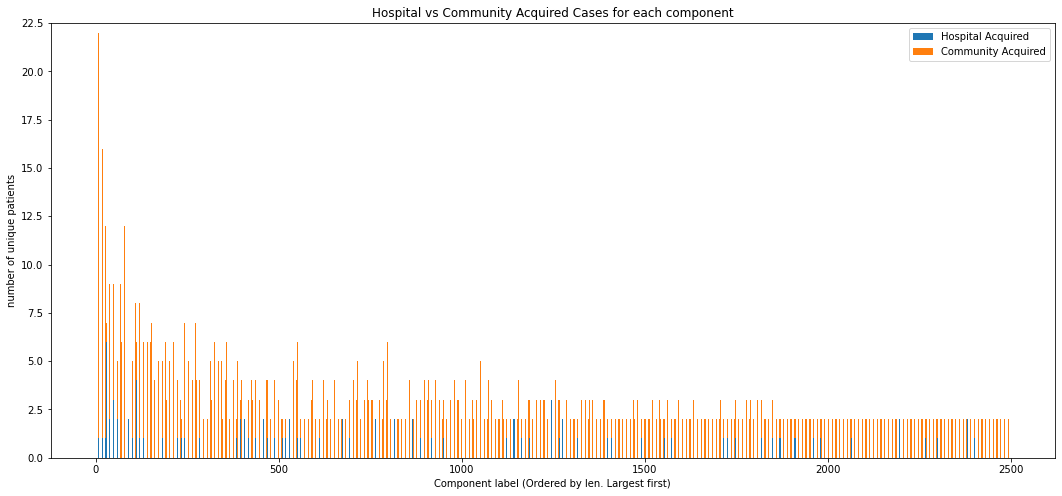

In [82]:
get_plot(acquired, title='Hospital vs Community Acquired Cases for each component')

# Comparing to Time-shuffled ensambles

In [97]:
# Load feature vectors from precomputed ensembles
feature_store = pd.read_csv('./data/random/ensemble_features_covid.csv', header=0, index_col=0)
scale_feature_store = pd.read_csv('./data/random/ensemble_scale_features_covid.csv', header=0, index_col=0)
complete = pd.read_csv('./data/random/ensemble_complete_covid.csv', header=0, index_col=0)

In [98]:
sample_vector = feature_store['sample']

feature_store = feature_store.fillna(0)
feature_store
scale_feature_store = scale_feature_store.fillna(0)
complete = complete.fillna(0)

In [99]:
from sklearn.preprocessing import Normalizer
# Rescale
rs_feature_store = Normalizer().fit_transform(feature_store)
rs_feature_store = pd.DataFrame(rs_feature_store, index=feature_store.index, columns=feature_store.columns)

rs_complete = Normalizer().fit_transform(complete)
rs_complete = pd.DataFrame(rs_complete, index=complete.index, columns=complete.columns)

In [100]:
distances = {}
for sample, group in rs_feature_store.groupby(sample_vector):
    distances[sample] = ((group - rs_complete.loc[sample])**2).sum(axis=1)

In [101]:
# Actual data distance
full, _ = generate_features({'full': filtered}, feature_spec=FEATURE_SPEC)

rs_full = Normalizer().fit_transform(full)
rs_full = pd.DataFrame(rs_full, index=full.index, columns=full.columns)
rs_full = rs_full.drop('reciprocity_ratio', axis=1)
actual_distance = (rs_features.subtract(rs_full.T.values[:,0])**2).sum(axis=1)

In [102]:
actual_distance.mean(), actual_distance.var(), len(actual_distance)

(1.404190755589062, 0.04047694873688351, 823)

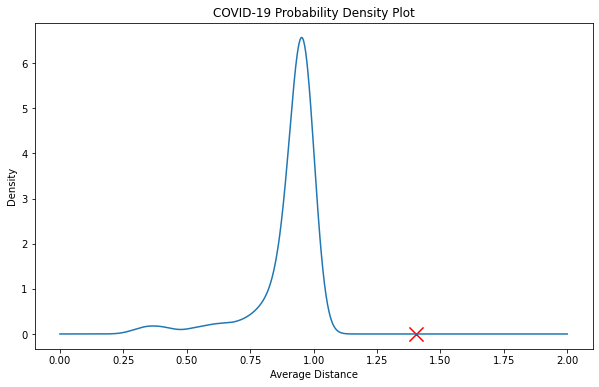

In [104]:
from scipy.stats import gaussian_kde

d = pd.Series([d.mean() for d in distances.values()])
kde = gaussian_kde(d)

x = np.linspace(0, 2,1000)

y = kde.evaluate(x)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(x,y)
ax.scatter([actual_distance.mean()],[0], marker='x', color='r', s=200)

ax.set_xlabel("Average Distance")
ax.set_ylabel("Density")
ax.set_title('COVID-19 Probability Density Plot')

plt.show()
fig.savefig('./figures/figure_8_distance.eps', bbox_inches='tight')

In [117]:
# z-score
d.mean(), d.std(), (actual_distance.mean() - d.mean())/ d.std()

(0.9027173966392076, 0.12599901552981937, 3.9799783898404666)

# Evolution of Time

In [60]:
filtered.add_cluster_assignments(clusters)

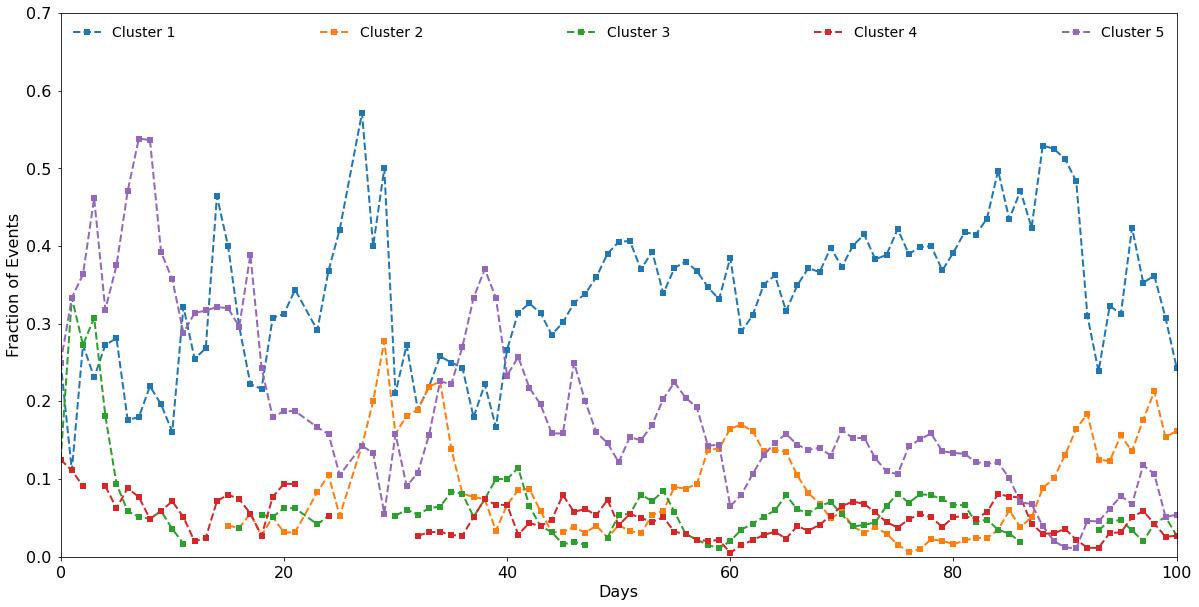

In [61]:

from eventgraphs.plotting import plot_cluster_timeseries

with plt.style.context(['seaborn-paper', PLOT_STYLE, {'legend.fontsize':14,
                                                      'legend.frameon':False}]):

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    plot_cluster_timeseries(filtered, interval_width=1, normalized=True, plot_unclustered=False, ax=ax);

    ax.set_xlabel("Days")
    ax.set_ylabel("Fraction of Events")

    ax.set_xlim(0,100) # the first 100 days - CHECK WHY ITS 100 because we only have 77 days duration period!!!!
    ax.set_ylim(0.0,0.7)

    #ax.set_xticks(np.linspace(-0.5,23.5,13))
    #ax.set_xticklabels([pd.to_datetime(x, unit='d').strftime("%D") for x in np.linspace(0,24,13)])

    legend = ax.legend(ncol=5, mode='expand')
    [x.set_text('Cluster {}'.format(x.get_text())) for x in legend.get_texts()]

    fig.savefig('./figures/figure_6_evolution.pdf', bbox_inches='tight')
plt.show()

In [62]:
den_clust, _ = find_clusters(rs_features, max_clusters=5)

In [63]:
clusters.equals(den_clust)

True

In [64]:
den_labels = den_clust.index

In [67]:

from eventgraphs.clustering import generate_distance_matrix, generate_linkage
from eventgraphs.plotting import plot_component_dendrogram
from scipy.cluster.hierarchy import set_link_color_palette

distances = generate_distance_matrix(rs_features)
Z = generate_linkage(distances)

with plt.style.context(['seaborn-paper', PLOT_STYLE]):

    fig = plt.figure(figsize=(200,100))
    ax = fig.add_subplot(111)

    set_link_color_palette(['C2', 'C3', 'C4', 'C1', 'C0'])

    plot_component_dendrogram(Z, dendrogram_kwargs={'leaf_rotation': 90, 
                                 'labels': den_labels, 
                                 'distance_sort': False, 
                                 'count_sort': True,
                                 'above_threshold_color': 'k', 'color_threshold': 37}, ax=ax);

    ax.set_xlabel("Temporal Component Clusters")
    #ax.set_ylim(0,30)

    #fig.savefig('./figures/figure_4_hierarchy.eps', bbox_inches='tight')